## Analyses of Sequence Features that Determine Compaction

This notebook reproduces Fig. 1, 3, and Extended Data Fig. 2, 5, 6e–t, and 7

Author: Giulio Tesei

Contact: giulio.tesei@bio.ku.dk

In [1]:
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import itertools
from ast import literal_eval
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import binned_statistic, binned_statistic_2d
import string
from matplotlib.colors import LogNorm
import warnings
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interp1d
warnings.filterwarnings('ignore')
# function to calculate standard error of the mean
se = lambda x : np.std(x)/np.sqrt(x.size)
se.__name__ = 'SE'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] + plt.rcParams['font.sans-serif']
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rc('pdf', fonttype=42)

def plotEnergyMap(ax,dmap,label,vmin,vmax,cmap=plt.cm.bwr,
            xlabel='Residue #',ylabel='Residue #',ori='vertical', #error bar can be vertical or horizontal
            cbar=True,n_ticks=4): #to show color gradient
    im = ax.imshow(dmap,extent=[1, dmap.shape[0], 1, dmap.shape[0]], 
                 cmap=cmap,
                 origin='lower',alpha=1,aspect='equal',
                 vmin=vmin,vmax=vmax) #makes bars
    if cbar:
        divider = make_axes_locatable(ax)
        if ori == 'vertical':
            cax = divider.new_horizontal(size="5%", pad=.1)
        else:
            cax = divider.new_vertical(size="5%", pad=.15)
        f.add_axes(cax)
        cb = f.colorbar(im, cax=cax, orientation=ori,
                    label=r'{:s}'.format(label))
        cax.xaxis.set_label_position('top'); cax.xaxis.set_ticks_position('top')
        cb.set_ticks([0,-3,-6,-9])
    if xlabel:
        ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    interval = round(dmap.shape[0]//n_ticks/10,0)*10
    ax.set_xticks([1, interval, interval*2, interval*3])
    ax.set_yticks([1, interval, interval*2, interval*3])
    return cb

oranges = [(0, 0, 0), '#EE7733', (1, 1, 1)] 
oranges = mpl.colors.LinearSegmentedColormap.from_list('oranges', oranges, N=1000)
oranges = mpl.colors.LinearSegmentedColormap.from_list(
          'trunc(oranges.name,.3,.99)', oranges(np.linspace(.3, .99, 1000)))
blues = [(0, 0, 0), '#33BBEE', (1, 1, 1)] 
blues = mpl.colors.LinearSegmentedColormap.from_list('blues', blues, N=1000)
blues = mpl.colors.LinearSegmentedColormap.from_list(
          'trunc(blues.name,.3,.99)', blues(np.linspace(.3, .99, 1000)))
greens = [(0, 0, 0), '#009988', (1, 1, 1)] 
greens = mpl.colors.LinearSegmentedColormap.from_list('greens', greens, N=1000)
greens = mpl.colors.LinearSegmentedColormap.from_list(
          'trunc(greens.name,.3,.99)', greens(np.linspace(.3, .99, 1000)))

dark_orange = oranges(np.arange(0,1.1,.1))[0]
dark_blue = blues(np.arange(0,1.1,.1))[0]
dark_green = greens(np.arange(0,1.1,.1))[0]

hexcolors = ['#EE7733', '#0077BB', '#33BBEE', '#EE3377', '#CC3311', '#009988', '#BBBBBB']
colornames = ['orange','blue','cyan','magenta','red','teal','grey']
pt_colors = dict(zip(colornames,hexcolors))

#os.environ['PATH']= os.environ['PATH']+':/Library/TeX/texbin'

In [2]:
# load IDRome database
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)
# load SPOT-based IDRome database
df_idrome_spot = pd.read_csv('IDRome_DB_SPOT.csv',index_col=0)

# load data from five independent MD simulations of 33 sequences
df_replicas = pd.read_csv('md_simulations/data/replicas_data.csv',index_col=0)

df_replicas.nu_replicas = df_replicas.nu_replicas.apply(lambda x : literal_eval(x))
df_replicas.ete2_Rg2_replicas = df_replicas.ete2_Rg2_replicas.apply(lambda x : literal_eval(x))

df_replicas['protein_name'] = df_idrome.loc[df_replicas.index].protein_name
df_replicas['scd'] = df_idrome.loc[df_replicas.index].scd
df_replicas['kappa'] = df_idrome.loc[df_replicas.index].kappa

In [3]:
df_idrome.query('is_nterm').shape[0]/df_idrome.shape[0]*100

32.16907833772899

In [4]:
df_idrome.query('is_cterm').shape[0]/df_idrome.shape[0]*100

24.812887589992158

In [5]:
df_idrome.query('is_idp').shape[0]/df_idrome.shape[0]*100

5.214199158885167

In [6]:
df_idrome.query('is_btw_folded').shape[0]/df_idrome.shape[0]*100

15.496471594554137

In [7]:
df_idrome.query('(nu > 0.45) and (nu <= 0.55)').nu.count()/df_idrome.shape[0]*100

66.09879535248415

#### Fig. 1b

Q99457_164_307
0.542


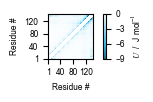

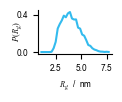

Q99457_1_97
0.4


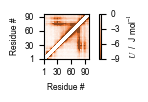

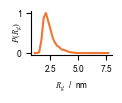

In [8]:
for name,n_ticks in zip(df_idrome[df_idrome.index.str.startswith('Q99457')].index,[4,3]):
    print(name)
    N = len(df_idrome.loc[name,'fasta'])
    print(df_idrome.loc[name].nu)
    emap = pd.read_csv(f'md_simulations/data/replicas/{name:s}_emap.csv.gz',index_col=0)
    
    if df_idrome.loc[name].nu <= 0.45:
        cmap = oranges
        color = pt_colors['orange']
    else:
        cmap = blues
        color = pt_colors['cyan']
    
    f = plt.figure(figsize=(1.4,1))
    plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})
    plotEnergyMap(plt.gca(),emap*1e3,'$U$  /  J mol$^{-1}$',-9,0,cmap=cmap,n_ticks=n_ticks)
    plt.tight_layout()
    plt.savefig('figs/'+name+'_emap.pdf',dpi=300)
    plt.show()
    
    f = plt.figure(figsize=(1.2,1))
    plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})
    rg = np.load(f'md_simulations/data/replicas/{name:s}_rgarray.npy')
    bins = np.arange(1,8,.2)
    x = bins[:-1]+(bins[1]-bins[0])/2.
    h,_ = np.histogram(rg,bins=bins,density=True)
    
    plt.plot(x,h,lw=1.5,color=color)
    plt.xlabel('$R_g$  /  nm')
    
    plt.ylim(-h.max()/20,h.max()*1.05)
    plt.yticks([0,round(h.max(),1)])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.ylabel('$P(R_g)$',labelpad=-5)
    plt.tight_layout()
    plt.savefig('figs/'+name+'_rg.pdf',dpi=300)
    plt.show()

#### Fig. 1c

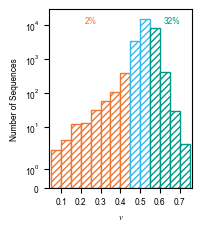

In [9]:
fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(2,2.3))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})
mpl.rcParams['pdf.fonttype'] = 42

N_tot = df_idrome.index.size
p_compact = df_idrome.query(f'nu <= 0.45').shape[0]/N_tot*100
p_expanded = df_idrome.query(f'nu > 0.55').shape[0]/N_tot*100
p_theta = 100-p_compact-p_expanded

intervals = pd.cut(df_idrome['nu'], np.arange(0.05, .76, .05))
sum_std = df_idrome['nu'].groupby(intervals).agg(['count'])
sum_std['count'].plot(rot=0, ax=ax, kind='bar',hatch='/////',color='w',
                      edgecolor=[pt_colors['orange']]*8+[pt_colors['cyan']]*2+[pt_colors['teal']]*4,width=1)

ax.annotate(f'{p_compact:.0f}%',xy=(.25,.92),xycoords='axes fraction',color=pt_colors['orange'],fontsize=6)
ax.annotate(f'{p_expanded:.0f}%',xy=(.8,.92),xycoords='axes fraction',color=pt_colors['teal'],fontsize=6)

ax.set_ylabel('Number of Sequences')
ax.set_xlabel(r'$\nu$')
ax.set_yscale('symlog')
ax.set_xticks(np.arange(sum_std.index.size)[::2]+.5)
ax.set_xticklabels([i.right for i in sum_std.index[::2]])

#ax.vlines([8.5,10.5],ymin=0,ymax=3e4,color='k',ls=':',lw=1)
ax.set_ylim(0,3e4)

plt.tight_layout()

fig.savefig('figs/fig1c.pdf',dpi=300)

#### Sample sizes in Fig. 3

In [10]:
bin_width = .015
bins = np.arange(0.14, .701, bin_width)
x = bins[:-1]+bin_width/2
for feature in ['mean_lambda','z_delta_+-','z_omega_-','z_omega_pi','SPR','fcr']:
    if feature == 'z_delta_+-':
        nonzero_bool = df_idrome['z_delta_+-'] != 0
    elif feature == 'z_omega_-':
        nonzero_bool = df_idrome['z_omega_-'] != 0
    elif feature == 'z_omega_pi':
        nonzero_bool = df_idrome['z_omega_pi'] != 0
    else:
        nonzero_bool = np.ones(df_idrome[feature].size,dtype=bool)
    counts = binned_statistic(df_idrome.nu.values[nonzero_bool],
                               df_idrome[feature].values[nonzero_bool],bins=bins,statistic='count')[0].astype(int)
    if feature == 'z_omega_pi':
        print(feature,'; '.join([str(x) for x in counts[(x>.41)&(x<.59)][counts[(x>.41)&(x<.59)]>2]]))
    else:
        print(feature,'; '.join([str(x) for x in counts[counts>2]]))

mean_lambda 4; 3; 5; 3; 5; 6; 9; 11; 8; 16; 14; 26; 23; 28; 41; 49; 98; 135; 212; 473; 854; 1921; 3319; 4724; 5393; 4987; 3405; 1461; 484; 182; 76; 43; 16; 9; 4
z_delta_+- 4; 3; 5; 3; 5; 6; 7; 11; 8; 14; 12; 24; 22; 22; 37; 39; 81; 106; 150; 323; 543; 1077; 1570; 1909; 1858; 1615; 951; 352; 84; 19; 5; 5
z_omega_- 4; 3; 5; 3; 5; 6; 8; 11; 8; 16; 13; 26; 23; 26; 38; 43; 91; 119; 181; 379; 637; 1316; 2061; 2737; 3001; 2855; 2051; 991; 379; 145; 63; 31; 15; 9; 4
z_omega_pi 10; 15; 34; 68; 112; 242; 342; 538; 602; 487; 223; 72
SPR 4; 3; 5; 3; 5; 6; 9; 11; 8; 16; 14; 26; 23; 28; 41; 49; 98; 135; 212; 473; 854; 1921; 3319; 4724; 5393; 4987; 3405; 1461; 484; 182; 76; 43; 16; 9; 4
fcr 4; 3; 5; 3; 5; 6; 9; 11; 8; 16; 14; 26; 23; 28; 41; 49; 98; 135; 212; 473; 854; 1921; 3319; 4724; 5393; 4987; 3405; 1461; 484; 182; 76; 43; 16; 9; 4


#### Fig. 3

MIN mean_lambda 0.4625000000000003
mean_lambda 0.43929082933027774 0.7527350612468828
MIN z_delta_+- 0.5375000000000003
z_delta_+- 7.848441598576762 19.02505696776819
MIN z_omega_- 0.5375000000000003
z_omega_- 7.876278565253687 23.76654631393603
MIN z_omega_pi 0.4625000000000003
z_omega_pi 1.7304699526979286 4.0082897049189405
MIN SPR 0.4775000000000003
SPR 11.16480951124485 11.383533701922603
MIN fcr 0.5375000000000003
fcr 0.6945415959252971 0.9583333333333334


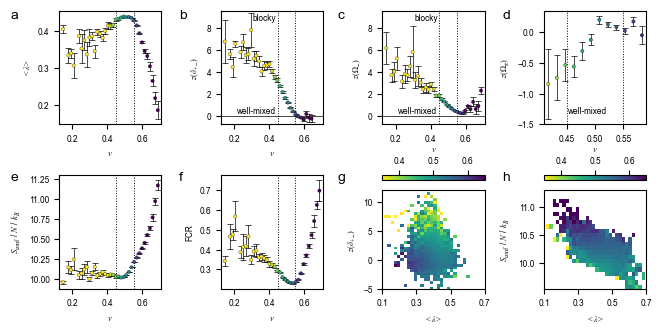

In [33]:
f, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(6.6,3.3))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

features = ['mean_lambda','z_delta_+-','z_omega_-','z_omega_pi','SPR','fcr']
labels = [r'$< \lambda >$','$z(\delta_{+-})$','$z(\Omega_{-})$','$z(\Omega_{\pi})$',
          r'$S_\mathrm{conf}$ / $N$ / $k_B$','FCR']

bin_width = .015
bins = np.arange(0.14, .701, bin_width)
x = bins[:-1]+bin_width/2

for ax,feature,label in zip([ax1,ax2,ax3,ax4,ax5,ax6],features,labels):
    
    if feature == 'z_delta_+-':
        nonzero_bool = df_idrome['z_delta_+-'] != 0
    elif feature == 'z_omega_-':
        nonzero_bool = df_idrome['z_omega_-'] != 0
    elif feature == 'z_omega_pi':
        nonzero_bool = df_idrome['z_omega_pi'] != 0
    else:
        nonzero_bool = np.ones(df_idrome[feature].size,dtype=bool)

    average = binned_statistic(df_idrome.nu.values[nonzero_bool],
                               df_idrome[feature].values[nonzero_bool],bins=bins)[0]
    standard_error = binned_statistic(df_idrome.nu.values[nonzero_bool],
                                      df_idrome[feature].values[nonzero_bool],statistic=se,
                                      bins=bins)[0]
    counts = binned_statistic(df_idrome.nu.values[nonzero_bool],
                               df_idrome[feature].values[nonzero_bool],bins=bins,statistic='count')[0]
    
    print('MIN',feature,x[(x>.45)&(x<=.55)][np.argmin(average[(x>.45)&(x<=.55)])])
    
    print(feature,np.nanmax(average),np.nanmax(df_idrome[feature]))

    ax.errorbar(x[counts>2],average[counts>2],yerr=standard_error[counts>2],ms=0,marker='o',lw=0,zorder=0,
             elinewidth=.5,capsize=2,capthick=.5,label=label,color='k')
    
    ax.scatter(x[counts>2],average[counts>2],marker='o',
                    c=x[counts>2],vmin=.4,vmax=.6,cmap=plt.cm.viridis_r,s=6,
                    edgecolor='k',lw=.2,zorder=10)

    ax.set_ylabel(label)
    
    ax.axvline(.45,color='k',ls=':',lw=.7)
    ax.axvline(.55,color='k',ls=':',lw=.7)
    ax.set_xlim(.125,.708)
    ax.set_xticks(np.arange(.2,.71,.2))

ax2.annotate('well-mixed',xy=(.54,.10),xycoords='axes fraction',fontsize=6,ha='right')
ax2.annotate('blocky',xy=(.54,.92),xycoords='axes fraction',fontsize=6,ha='right')
ax3.annotate('well-mixed',xy=(.54,.10),xycoords='axes fraction',fontsize=6,ha='right')
ax3.annotate('blocky',xy=(.54,.92),xycoords='axes fraction',fontsize=6,ha='right')
ax4.annotate('well-mixed',xy=(.62,.10),xycoords='axes fraction',fontsize=6,ha='right')

ax1.set_xlabel('$\\nu$')
ax2.set_xlabel('$\\nu$')
ax5.set_xlabel('$\\nu$')
ax6.set_xlabel('$\\nu$')
ax4.set_xlim(.41,.59)
ax4.set_ylim(-1.5,.35)
ax4.set_xticks(np.array([.45,.5,.55]))

#############

feature = 'z_delta_+-'
label = '$z(\delta_{+-})$'
interval = .5
decimal = 1
ybins = np.round(np.arange(df_idrome[feature].min(),df_idrome[feature].max(),interval),decimal)
xbins = np.round(np.arange(.1,.702,0.02),2)
ybins_center = ybins[:-1] + interval/2
xbins_center = xbins[:-1] + 0.02/2
nonzero_bool = df_idrome['z_delta_+-'] != 0
h,_,_,_ = binned_statistic_2d(df_idrome[feature].values[nonzero_bool],
                              df_idrome.mean_lambda.values[nonzero_bool],
            bins=[ybins,xbins],
            values=df_idrome.nu.values[nonzero_bool],statistic='mean')
im = ax7.imshow(h, cmap=plt.cm.viridis_r,
                 origin='lower',alpha=1,extent=[xbins_center.min(),xbins_center.max(),
                                               ybins_center.min(),ybins_center.max()],
                 vmin=.35,vmax=.65,aspect='auto',interpolation='nearest')
ax7.set_xlabel(r'$< \lambda >$')
ax7.set_ylim(-5,12)
ax7.set_xticks([.1,.3,.5,.7])
#ax7.set_xlim(.1,.62)
ax7.set_ylabel(label)
divider = make_axes_locatable(ax7)
cax = divider.new_vertical(size="{:.1f}%".format(5), pad=.1)
f.add_axes(cax)
cb = f.colorbar(im, cax=cax, orientation='horizontal',ticks=[.4, .5, .6],
            label='$\\nu$')
cax.xaxis.set_label_position('top'); cax.xaxis.set_ticks_position('top')

#############

feature = 'SPR'
label = r'$S_\mathrm{conf}$ / $N$ / $k_B$'
interval = .08
decimal = 2

ybins = np.round(np.arange(df_idrome[feature].min(),df_idrome[feature].max(),interval),decimal)
xbins = np.round(np.arange(.1,.702,0.02),2)

ybins_center = ybins[:-1] + interval/2
xbins_center = xbins[:-1] + 0.02/2

h,_,_,_ = binned_statistic_2d(df_idrome[feature],
                              df_idrome.mean_lambda,
            bins=[ybins,xbins],
            values=df_idrome.nu,statistic='mean')
im = ax8.imshow(h, cmap=plt.cm.viridis_r,
                 origin='lower',alpha=1,extent=[xbins_center.min(),xbins_center.max(),
                                               ybins_center.min(),ybins_center.max()],
                 vmin=.35,vmax=.65,aspect='auto',interpolation='nearest')
ax8.set_xlabel(r'$< \lambda >$')
ax8.set_xticks([.1,.3,.5,.7])
ax8.set_xticklabels([.1,.3,.5,.7])
#ax8.set_xlim(.1,.62)
ax8.set_ylabel(label)
divider = make_axes_locatable(ax8)
cax = divider.new_vertical(size="{:.1f}%".format(5), pad=.1)
f.add_axes(cax)
cb = f.colorbar(im, cax=cax, orientation='horizontal',ticks=[.4,.5,.6],
            label='$\\nu$')
cax.xaxis.set_label_position('top'); cax.xaxis.set_ticks_position('top')

#############
    
ax2.axhline(0,lw=.5,color='k')
ax3.axhline(0,lw=.5,color='k')

ax2.set_ylim(-.8,9.6)
ax3.set_ylim(-.8,9.6)
    
f.text(0.015, .95, 'a', fontsize=10)
f.text(0.27, .95, 'b', fontsize=10)
f.text(0.51, .95, 'c', fontsize=10)
f.text(0.76, .95, 'd', fontsize=10)

f.text(0.015, .46, 'e', fontsize=10)
f.text(0.27, .46, 'f', fontsize=10)
f.text(0.51, .46, 'g', fontsize=10)
f.text(0.76, .46, 'h', fontsize=10)
    
plt.tight_layout(h_pad=.1)
plt.savefig('figs/fig3.pdf',dpi=300)

#### Extended Data Fig. 2

P08621
P06748
Q5VUA4
Q6PD62
Q15648
Q13148
P98177
Q7KZ85
P06454
Q5BKZ1
O60763
Q99733


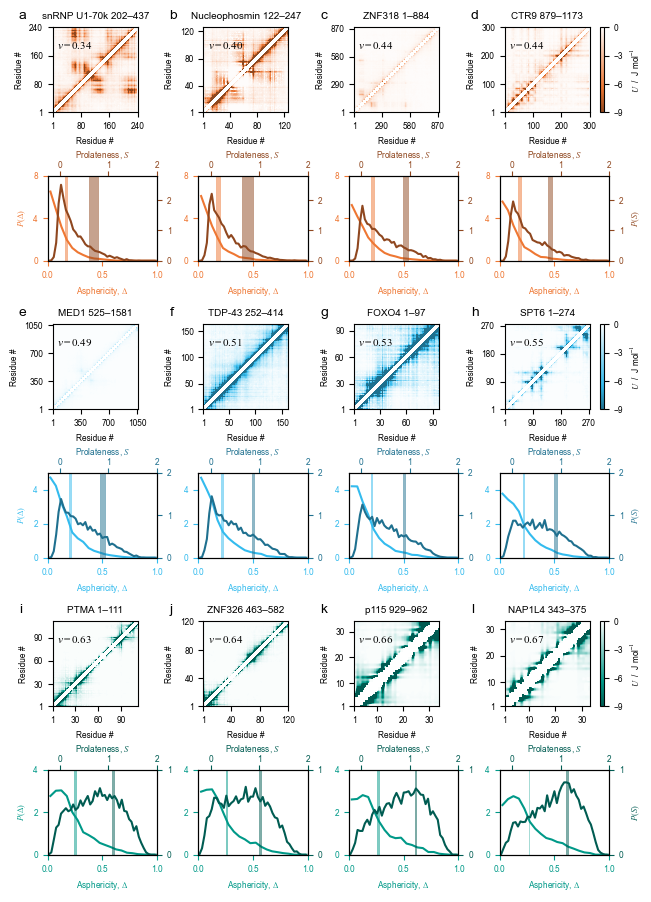

In [14]:
f, (r1,r2,r3,r4,r5,r6) = plt.subplots(6, 4, sharex=False, sharey=False, figsize=(6.6,9))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})
mpl.rcParams['pdf.fonttype'] = 42

proteins = ['P08621_202_437','Q5VUA4_1_884','P06748_122_247','Q6PD62_879_1173',
'Q13148_252_414','Q15648_525_1581','Q7KZ85_1_274','P98177_1_97',
'P06454_1_111','Q5BKZ1_463_582','O60763_929_962','Q99733_343_375']

labels = ['snRNP U1-70k','ZNF318','Nucleophosmin','CTR9','TDP-43','MED1',
 'SPT6','FOXO4','PTMA','ZNF326','p115','NAP1L4']

label_dict = {p: l for p,l in zip(proteins,labels)}

ax_map = np.concatenate([r1,r3,r5])
ax_a = np.concatenate([r2,r4,r6])

for i,name in enumerate(df_replicas.loc[proteins].sort_values('nu').index):
    emap = pd.read_csv(f'md_simulations/data/replicas/{name:s}_emap.csv.gz',index_col=0)
    
    if df_replicas.loc[name].nu <= 0.45:
        cmap = oranges
        color = pt_colors['orange']
        dark_color = dark_orange
    elif df_replicas.loc[name].nu > 0.55:
        cmap = greens
        color = pt_colors['teal']
        dark_color = dark_green
    else:
        cmap = blues
        color = pt_colors['cyan']
        dark_color = dark_blue
        
    n_ticks = 4 if i == 8 else 3
    
    cb = plotEnergyMap(ax_map[i],emap*1e3,'$U$  /  J mol$^{-1}$',-9,0,cmap=cmap,n_ticks=n_ticks)
    
    round_int = abs(int(np.log10(df_replicas.loc[name,'nu_err'])))+1
    
    nu = round(df_replicas.loc[name,'nu'],round_int)
    nu_err = round(df_replicas.loc[name,'nu_err'],round_int)
    
    ax_map[i].annotate('$\\nu={:.2f}$'.format(nu),
                      xy=(.05,.75),xycoords='axes fraction',fontsize=8)
    
    ax_map[i].annotate(string.ascii_lowercase[i],xy=(-.4,1.1),xycoords='axes fraction',fontsize=10)
    #ax_a[i].set_title('$\\nu={:#.3g}\pm{:#.3g}$'.format(nu,nu_err))
    
    if i in [0,4,8]:
        ax_a[i].set_ylabel('$P(\Delta)$',color=color)
    
    ax_a[i].set_xlabel('Asphericity, $\Delta$',color=color)
    ax_a[i].tick_params(axis='x',colors=color)
    ax_a[i].tick_params(axis='y',colors=color)
    ax_a[i].set_xlim(0,1)
    ax_a[i].set_xticks([0,.5,1])
    
    if i not in [3,7,11]:
        cb.remove() 
        
    s = np.load(f'md_simulations/data/replicas/{name:s}_Delta_array.npy')
    bins = np.arange(0,1.02,.05)
    x = bins[:-1]+(bins[1]-bins[0])/2.
    h,_ = np.histogram(s,bins=bins,density=True)
    ax_a[i].plot(x,h,lw=1.5,color=color)
    
    ax_s = inset_axes(ax_a[i], width="100%", height="100%", loc='lower left', borderpad=0)
    ax_s.patch.set_alpha(0)
    if i in [3,7,11]:
        ax_s.set_ylabel('$P(S)$',color=dark_color)
    s = np.load(f'md_simulations/data/replicas/{name:s}_S_array.npy')
    bins = np.arange(-.25,2.02,.05)
    x = bins[:-1]+(bins[1]-bins[0])/2.
    h,_ = np.histogram(s,bins=bins,density=True)
    ax_s.plot(x,h,lw=1.5,color=dark_color)
    ax_s.yaxis.set_ticks_position('right'); ax_s.yaxis.set_label_position('right')
    ax_s.xaxis.set_ticks_position('top'); ax_s.xaxis.set_label_position('top')
    ax_s.set_xlabel('Prolateness, $S$',color=dark_color,labelpad=2)  
    ax_s.tick_params(axis='x',colors=dark_color)
    ax_s.tick_params(axis='y',colors=dark_color)
    ax_s.set_xlim(-.25,2)
    ax_s.tick_params(axis='x', which='major', pad=1)
    
    if i < 4:
        ax_a[i].set_ylim(0,8)
        ax_a[i].set_yticks([0,4,8])
        ax_a[i].axvspan(df_replicas.loc[name,'Delta']-df_replicas.loc[name,'Delta_err'], 
                        df_replicas.loc[name,'Delta']+df_replicas.loc[name,'Delta_err'], 
                        alpha=0.5, lw=0.5, color=pt_colors['orange'])
    elif i > 7:
        ax_a[i].set_ylim(0,4)
        ax_a[i].set_yticks([0,2,4])
        ax_a[i].axvspan(df_replicas.loc[name,'Delta']-df_replicas.loc[name,'Delta_err'], 
                        df_replicas.loc[name,'Delta']+df_replicas.loc[name,'Delta_err'], 
                        alpha=0.5, lw=0.5, color=pt_colors['teal'])
    else:
        ax_a[i].set_ylim(0,5)
        ax_a[i].set_yticks([0,2,4])
        ax_a[i].axvspan(df_replicas.loc[name,'Delta']-df_replicas.loc[name,'Delta_err'], 
                        df_replicas.loc[name,'Delta']+df_replicas.loc[name,'Delta_err'], 
                        alpha=0.5, lw=0.5, color=pt_colors['cyan'])
        
    if i < 4:
        ax_s.set_ylim(0,2.8)
        ax_s.axvspan(df_replicas.loc[name,'S']-df_replicas.loc[name,'S_err'], 
                        df_replicas.loc[name,'S']+df_replicas.loc[name,'S_err'], alpha=0.5, 
                     lw=0.5, color=dark_orange)
    elif i > 7:
        ax_s.set_ylim(0,1)
        ax_s.set_yticks([0,1])
        ax_s.axvspan(df_replicas.loc[name,'S']-df_replicas.loc[name,'S_err'], 
                        df_replicas.loc[name,'S']+df_replicas.loc[name,'S_err'], alpha=0.5, 
                     lw=0.5, color=dark_green)
    else:
        ax_s.set_ylim(0,2)
        ax_s.set_yticks([0,1,2])
        ax_s.axvspan(df_replicas.loc[name,'S']-df_replicas.loc[name,'S_err'], 
                        df_replicas.loc[name,'S']+df_replicas.loc[name,'S_err'], alpha=0.5, 
                     lw=0.5, color=dark_blue)
        
    print(df_idrome.loc[name,'UniProt_ID'])
    ax_map[i].set_title(label_dict[name]+' {:d}–{:d}'.format(
                        df_idrome.loc[name,'first'],df_idrome.loc[name,'last']))
    
plt.tight_layout()
plt.savefig('figs/ED_fig2.jpg',dpi=600)

#### Extended Data Fig. 5

#### Calculate $\Delta \nu$ between IDRs separated by folded domains within the same protein

In [15]:
df = df_idrome.query('is_btw_folded')
IDs_multiple_IDRs = df[['N','UniProt_ID']].groupby('UniProt_ID').count()
IDs_multiple_IDRs = IDs_multiple_IDRs[IDs_multiple_IDRs.N>1].index

df_same_ID_btw_folded = pd.DataFrame()

cnt = 0
for UniProt_ID in IDs_multiple_IDRs: 
    df_ID = df.query(f'UniProt_ID == "{UniProt_ID:s}"')[['nu','first','last']]
    df_ID['first_last'] = df_ID[['first', 'last']].values.tolist()
    delta_nus = np.diff(list(itertools.combinations(df_ID.nu,2))).flatten()
    mean_nus = np.mean(list(itertools.combinations(df_ID.nu,2)),axis=1).flatten()
    first_last = [list(itertools.product(x[0], x[1])) for x in list(itertools.combinations(df_ID.first_last,2))]
    dists = [np.abs(np.diff(x)).min() for x in first_last]
    for delta_nu,mean_nu,dist in zip(delta_nus,mean_nus,dists):
        df_same_ID_btw_folded.loc[cnt,'UniProt_ID'] = UniProt_ID
        df_same_ID_btw_folded.loc[cnt,'delta_nu'] = delta_nu
        df_same_ID_btw_folded.loc[cnt,'mean_nu'] = mean_nu
        df_same_ID_btw_folded.loc[cnt,'dist'] = dist
        cnt += 1

#### Calculate $\Delta \nu$ between all IDRs within the same protein

In [16]:
df = df_idrome
IDs_multiple_IDRs = df[['N','UniProt_ID']].groupby('UniProt_ID').count()
IDs_multiple_IDRs = IDs_multiple_IDRs[IDs_multiple_IDRs.N>1].index

df_same_ID = pd.DataFrame()

cnt = 0
for UniProt_ID in IDs_multiple_IDRs: 
    df_ID = df.query(f'UniProt_ID == "{UniProt_ID:s}"')[['nu','first','last']]
    df_ID['first_last'] = df_ID[['first', 'last']].values.tolist()
    delta_nus = np.diff(list(itertools.combinations(df_ID.nu,2))).flatten()
    mean_nus = np.mean(list(itertools.combinations(df_ID.nu,2)),axis=1).flatten()
    first_last = [list(itertools.product(x[0], x[1])) for x in list(itertools.combinations(df_ID.first_last,2))]
    dists = [np.abs(np.diff(x)).min() for x in first_last]
    for delta_nu,mean_nu,dist in zip(delta_nus,mean_nus,dists):
        df_same_ID.loc[cnt,'UniProt_ID'] = UniProt_ID
        df_same_ID.loc[cnt,'delta_nu'] = delta_nu
        df_same_ID.loc[cnt,'mean_nu'] = mean_nu
        df_same_ID.loc[cnt,'dist'] = dist
        cnt += 1

#### Calculate $\Delta \nu$ between IDRs of different proteins

In [17]:
if not os.path.isfile('md_simulations/data/delta_nu_diff_prot.npy'):
    nu_diff_prot = np.diff(list(itertools.combinations(df_idrome.nu,2))).flatten()

    ID_diff_prot = list(itertools.combinations(df_idrome.UniProt_ID,2))

    bool_different = [x[0]!=x[1] for x in ID_diff_prot]

    nu_diff_prot = nu_diff_prot[bool_different]

    delta_nu_dict = {'delta_nu_mean':np.abs(nu_diff_prot).mean(),
                       'delta_nu_SE':se(np.abs(nu_diff_prot)),
                       'delta_nu_SD':np.abs(nu_diff_prot).std(),
                       'delta_nu_N':nu_diff_prot.size}
    np.save('md_simulations/data/delta_nu_diff_prot.npy', delta_nu_dict)
    
    bin_width = .002
    bins = np.arange(0, 1.0, bin_width)
    x = bins[:-1] + bin_width/2

    h = np.histogram(np.abs(nu_diff_prot),bins=bins,density=True)[0]
    np.save('md_simulations/data/delta_nu_diff_ID_hist.npy',h)

#### Extended Data Fig. 5

Dnu Different Protein 393586617
Dnu Same Protein 25036
Dnu Between Folded 2216
Ttest_indResult(statistic=13.764340084278764, pvalue=4.176903450143681e-43)
Ttest_indResult(statistic=7.56500971831322, pvalue=3.878364442442272e-14)


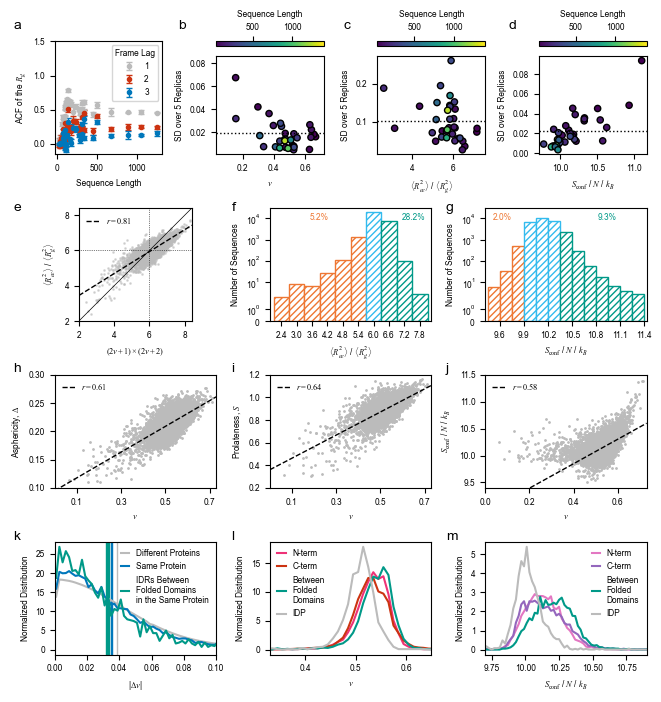

In [24]:
f = plt.figure(figsize=(6.6,7))
ax1 = plt.subplot2grid( (4,12), (1,0), rowspan=1, colspan=4 )
ax2 = plt.subplot2grid( (4,12), (1,4), rowspan=1, colspan=4 )
ax3 = plt.subplot2grid( (4,12), (1,8), rowspan=1, colspan=4 )
ax4 = plt.subplot2grid( (4,12), (2,0), rowspan=1, colspan=4 )
ax5 = plt.subplot2grid( (4,12), (2,4), rowspan=1, colspan=4 )
ax6 = plt.subplot2grid( (4,12), (2,8), rowspan=1, colspan=4 )
ax7 = plt.subplot2grid( (4,12), (3,0), rowspan=1, colspan=4 )
ax8 = plt.subplot2grid( (4,12), (3,4), rowspan=1, colspan=4 )
ax9 = plt.subplot2grid( (4,12), (3,8), rowspan=1, colspan=4 )
ax10 = plt.subplot2grid( (4,12), (0,0), rowspan=1, colspan=3 )
ax11 = plt.subplot2grid( (4,12), (0,3), rowspan=1, colspan=3 )
ax12 = plt.subplot2grid( (4,12), (0,6), rowspan=1, colspan=3 )
ax13 = plt.subplot2grid( (4,12), (0,9), rowspan=1, colspan=3 )
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})
mpl.rcParams['pdf.fonttype'] = 42

N_tot = df_idrome.index.size

df_idrome['ete2_Rg2_calc'] = (2*df_idrome.nu+1)*(2*df_idrome.nu+2)

ax1.plot(df_idrome.ete2_Rg2_calc,df_idrome.ete2_Rg2,ms=1,marker='o',lw=0,color=pt_colors['grey'],alpha=.5)
ax1.set_ylabel(r'$\langle R_{ee}^2 \rangle$ / $\langle R_g^2 \rangle$')
ax1.set_xlabel(r'$(2\nu+1)\times(2\nu+2)$')
x = np.linspace(2,8.4,100)
pr = pearsonr(df_idrome.ete2_Rg2_calc,df_idrome.ete2_Rg2)[0]
popt,_ = curve_fit(lambda x,a,b : a*x+b,df_idrome.ete2_Rg2_calc,df_idrome.ete2_Rg2)
ax1.plot(x,popt[0]*x+popt[1],ls='--',lw=1,label='$r={:.2f}$'.format(pr),zorder=4,color='k')
ax1.plot(x,x,lw=.5,zorder=4,color='k')

ax1.set_xlim(2,8.4)
ax1.set_ylim(2,8.4)
ax1.set_aspect('equal')

ax1.vlines(6,ymin=2,ymax=8.4,color='k',ls=':',lw=0.5)
ax1.hlines(6,xmin=2,xmax=8.4,color='k',ls=':',lw=0.5)

ax1.legend(frameon=False,loc='upper left',handlelength=1.5)

##########

p_compact = df_idrome.query('ete2_Rg2 <= 5.7').shape[0]/N_tot*100
p_expanded = df_idrome.query('ete2_Rg2 > 6.3').shape[0]/N_tot*100
p_theta = 100-p_compact-p_expanded

intervals = pd.cut(df_idrome['ete2_Rg2'], np.arange(2.1, 8.2, .6))
sum_std = df_idrome['ete2_Rg2'].groupby(intervals).agg(['count'])
sum_std['count'].plot(rot=0, ax=ax2, kind='bar',hatch='/////',color='w',
                      edgecolor=[pt_colors['orange']]*6+[pt_colors['cyan']]*1+[pt_colors['teal']]*3,width=1)

ax2.annotate(f'{p_compact:.1f}%',xy=(.25,.895),xycoords='axes fraction',color=pt_colors['orange'],fontsize=6)
ax2.annotate(f'{p_expanded:.1f}%',xy=(.82,.895),xycoords='axes fraction',color=pt_colors['teal'],fontsize=6)

ax2.set_ylabel('Number of Sequences')
ax2.set_xlabel(r'$\langle R_{ee}^2 \rangle$ / $\langle R_g^2 \rangle$')
ax2.set_yscale('symlog')

ax2.set_xticks(np.arange(sum_std.index.size))
ax2.set_xticklabels([round(i.right-.3,1) for i in sum_std.index])

ax2.set_ylim(0,3e4)

##########

p_compact = df_idrome.query('SPR <= 9.9').shape[0]/N_tot*100
p_expanded = df_idrome.query('SPR > 10.35').shape[0]/N_tot*100
p_theta = 100-p_compact-p_expanded

intervals = pd.cut(df_idrome['SPR'], np.arange(9.45, 11.4, .15))
sum_std = df_idrome['SPR'].groupby(intervals).agg(['count'])

sum_std['count'].plot(rot=0, ax=ax3, kind='bar',hatch='/////',color='w',
                      edgecolor=[pt_colors['orange']]*3+[pt_colors['cyan']]*3+[pt_colors['teal']]*8,width=1)

ax3.annotate(f'{p_compact:.1f}%',xy=(.05,.895),xycoords='axes fraction',color=pt_colors['orange'],fontsize=6)
ax3.annotate(f'{p_expanded:.1f}%',xy=(.7,.895),xycoords='axes fraction',color=pt_colors['teal'],fontsize=6)

ax3.set_ylabel('Number of Sequences')
ax3.set_xlabel(r'$S_\mathrm{conf}$ / $N$ / $k_B$')
ax3.set_yscale('symlog')

ax3.set_xticks(np.arange(sum_std.index.size)[::2]+.5)
ax3.set_xticklabels([i.right for i in sum_std.index[::2]])

ax3.set_ylim(0,3e4)

##########

ax4.plot(df_idrome.nu,df_idrome.Delta,ms=1,marker='o',lw=0,color=pt_colors['grey'])
ax5.plot(df_idrome.nu,df_idrome.S,ms=1,marker='o',lw=0,color=pt_colors['grey'])
ax6.plot(df_idrome.nu,df_idrome.SPR,ms=1,marker='o',lw=0,color=pt_colors['grey'])
ax4.set_ylabel('Asphericity, $\Delta$')
ax5.set_ylabel('Prolateness, $S$')
ax6.set_ylabel(r'$S_\mathrm{conf}$ / $N$ / $k_B$')
ax4.set_xlabel('$\\nu$')
ax5.set_xlabel('$\\nu$')
ax6.set_xlabel('$\\nu$')

x = np.linspace(0,0.73,100)

pr = pearsonr(df_idrome.nu,df_idrome.Delta)[0]
popt,_ = curve_fit(lambda x,a,b : a*x+b,df_idrome.nu,df_idrome.Delta)
ax4.plot(x,popt[0]*x+popt[1],ls='--',lw=1,label=f'$r={pr:.2f}$',zorder=4,color='k')
ax4.legend(frameon=False,handlelength=1.5)
ax4.set_xlim(0,.73)
ax4.set_ylim(.1,.3)
ax4.set_yticks([.1,.15,.2,.25,.3])

pr = pearsonr(df_idrome.nu,df_idrome.S)[0]
popt,_ = curve_fit(lambda x,a,b : a*x+b,df_idrome.nu,df_idrome.S)
ax5.plot(x,popt[0]*x+popt[1],ls='--',lw=1,label=f'$r={pr:.2f}$',zorder=4,color='k')
ax5.legend(frameon=False,handlelength=1.5)
ax5.set_xlim(0,.73)
ax5.set_ylim(0.2,1.2)

pr = pearsonr(df_idrome.nu,df_idrome.SPR)[0]
popt,_ = curve_fit(lambda x,a,b : a*x+b,df_idrome.nu,df_idrome.SPR)
ax6.plot(x,popt[0]*x+popt[1],ls='--',lw=1,label=f'$r={pr:.2f}$',zorder=4,color='k')
ax6.legend(frameon=False,handlelength=1.5)
ax6.set_xlim(0,.73)
ax6.set_ylim(9.4,11.5)

ax4.set_xticks([.1,.3,.5,.7])
ax5.set_xticks([.1,.3,.5,.7])

############

categories = ['is_nterm','is_cterm','is_btw_folded','is_idp']
labels = ['N-term','C-term','Between\nFolded\nDomains','IDP']

bin_width = .002
bins = np.arange(0, 1.0, bin_width)
x = bins[:-1] + bin_width/2

h = np.load('md_simulations/data/delta_nu_diff_ID_hist.npy')
delta_nu_dict = np.load('md_simulations/data/delta_nu_diff_prot.npy', allow_pickle='TRUE').item()
        
ax7.plot(x[h>0],h[h>0],label='Different Proteins',color=pt_colors['grey'])

print('Dnu Different Protein',delta_nu_dict['delta_nu_N'])
print('Dnu Same Protein',df_same_ID.shape[0])
print('Dnu Between Folded',df_same_ID_btw_folded.shape[0])

h = np.histogram(np.abs(df_same_ID.delta_nu),bins=bins,density=True)[0]
ax7.plot(x[h>0],h[h>0],label='Same Protein',color=pt_colors['blue'])

print(stats.ttest_ind_from_stats(mean1=delta_nu_dict['delta_nu_mean'], std1=delta_nu_dict['delta_nu_SD'], 
                     nobs1=delta_nu_dict['delta_nu_N'],
                     mean2=np.abs(df_same_ID.delta_nu).mean(), 
                     std2=np.abs(df_same_ID.delta_nu).std(), 
                     nobs2=df_same_ID.delta_nu.size))
    
h = np.histogram(np.abs(df_same_ID_btw_folded.delta_nu),bins=bins,density=True)[0]
ax7.plot(x[h>0],h[h>0],label='IDRs Between\nFolded Domains\nin the Same Protein',color=pt_colors['teal'])

print(stats.ttest_ind_from_stats(mean1=delta_nu_dict['delta_nu_mean'], std1=delta_nu_dict['delta_nu_SD'], 
                     nobs1=delta_nu_dict['delta_nu_N'],
                     mean2=np.abs(df_same_ID_btw_folded.delta_nu).mean(), 
                     std2=np.abs(df_same_ID_btw_folded.delta_nu).std(), 
                     nobs2=df_same_ID_btw_folded.delta_nu.size))

ax7.axvspan(np.abs(df_same_ID_btw_folded.delta_nu).mean()-se(df_same_ID_btw_folded.delta_nu),
            np.abs(df_same_ID_btw_folded.delta_nu).mean()+se(df_same_ID_btw_folded.delta_nu),
            color=pt_colors['teal'])
ax7.axvspan(np.abs(df_same_ID.delta_nu).mean()-se(df_same_ID.delta_nu),
            np.abs(df_same_ID.delta_nu).mean()+se(df_same_ID.delta_nu),color=pt_colors['blue'])
ax7.axvspan(delta_nu_dict['delta_nu_mean']-delta_nu_dict['delta_nu_SE'],
            delta_nu_dict['delta_nu_mean']+delta_nu_dict['delta_nu_SE'],color=pt_colors['grey'])
    
ax7.set_ylabel('Normalized Distribution')
ax7.set_xlabel(r'|$\Delta \nu$|')
ax7.set_xlim(0,.1)
ax7.legend(frameon=False,handlelength=1)

for bool_loc,label,c in zip(categories,labels,[pt_colors['magenta'],pt_colors['red'],
                                               pt_colors['teal'],pt_colors['grey']]):
    bins = np.arange(0.05, .74, .01)
    x = bins[:-1]+.005
    h = np.histogram(df_idrome.query(bool_loc).nu,bins=bins,density=True)[0]
    ax8.plot(x,h,label=label,color=c)
    ax8.set_ylabel('Normalized Distribution')
    ax8.set_xlabel(r'$\nu$')
    ax8.set_xlim(.33,.65)
    
    ax8.legend(frameon=False,handlelength=1,loc='upper left')
    
for bool_loc,label,c in zip(categories,labels,['tab:pink','tab:purple',pt_colors['teal'],pt_colors['grey']]):
    bin_width = .02
    bins = np.arange(9.5, 11, bin_width)
    x = bins[:-1]+bin_width/2
    h = np.histogram(df_idrome.query(bool_loc).SPR,bins=bins,density=True)[0]
    ax9.plot(x,h,label=label,color=c)
    ax9.set_ylabel('Normalized Distribution')
    ax9.set_xlabel(r'$S_\mathrm{conf}$ / $N$ / $k_B$')
    ax9.set_xlim(9.7,10.9)
    ax9.legend(frameon=False,handlelength=1)
    
###########

ax10.errorbar(df_replicas.N,df_replicas.acf_rg_1,yerr=df_replicas.acf_rg_1_err,ms=3,marker='o',lw=0,
         elinewidth=1,capsize=2,capthick=1,label='1',color=pt_colors['grey'])
ax10.errorbar(df_replicas.N,df_replicas.acf_rg_2,yerr=df_replicas.acf_rg_2_err,ms=3,marker='o',lw=0,
         elinewidth=1,capsize=2,capthick=1,label='2',color=pt_colors['red'])
ax10.errorbar(df_replicas.N,df_replicas.acf_rg_3,yerr=df_replicas.acf_rg_3_err,ms=3,marker='o',lw=0,
         elinewidth=1,capsize=2,capthick=1,label='3',color=pt_colors['blue'])

scat = ax11.scatter(df_replicas.nu, df_replicas.nu_err, marker='o',
                    c=df_replicas.N,vmin=30,vmax=1400,cmap=plt.cm.viridis,s=20,
                    edgecolor='k',zorder=2)
divider = make_axes_locatable(ax11)
cax = divider.new_vertical(size="5%", pad=0.1)
f.add_axes(cax)
cbar = plt.colorbar(scat, cax=cax, orientation='horizontal')
cbar.set_label('Sequence Length',labelpad=4)
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')

scat = ax12.scatter(df_replicas.ete2_Rg2, df_replicas.ete2_Rg2_err, marker='o',
                    c=df_replicas.N,vmin=30,vmax=1400,cmap=plt.cm.viridis,s=20,
                    edgecolor='k',zorder=2)
divider = make_axes_locatable(ax12)
cax = divider.new_vertical(size="5%", pad=0.1)
f.add_axes(cax)
cbar = plt.colorbar(scat, cax=cax, orientation='horizontal')
cbar.set_label('Sequence Length',labelpad=4)
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')

scat = ax13.scatter(df_replicas.SPR, df_replicas.SPR_err, marker='o',
                    c=df_replicas.N,vmin=30,vmax=1400,cmap=plt.cm.viridis,s=20,
                    edgecolor='k',zorder=2)
divider = make_axes_locatable(ax13)
cax = divider.new_vertical(size="5%", pad=0.1)
f.add_axes(cax)
cbar = plt.colorbar(scat, cax=cax, orientation='horizontal')
cbar.set_label('Sequence Length',labelpad=4)
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')

ax10.set_ylabel('ACF of the $R_g$')
ax10.set_xlabel('Sequence Length')
ax10.set_ylim(-.15,1.5)

ax11.axhline(df_replicas.nu_err.mean(),color='k',ls=':',lw=1)
ax11.set_xlim(.03,.72)

ax12.axhline(df_replicas.ete2_Rg2_err.mean(),color='k',ls=':',lw=1)
ax12.set_xlim(2.3,7.6)

ax13.axhline(df_replicas.SPR_err.mean(),color='k',ls=':',lw=1)

ax10.legend(title='Frame Lag',ncol=1)
ax11.set_ylabel('SD over 5 Replicas')
ax11.set_xlabel('$\\nu$')

ax12.set_ylabel('SD over 5 Replicas')
ax12.set_xlabel(r'$\langle R_{ee}^2 \rangle$ / $\langle R_g^2 \rangle$')

ax13.set_ylabel('SD over 5 Replicas')
ax13.set_xlabel(r'$S_\mathrm{conf}$ / $N$ / $k_B$')

f.text(0.02, .96, 'a', fontsize=10)
f.text(0.27, .96, 'b', fontsize=10)
f.text(0.52, .96, 'c', fontsize=10)
f.text(0.77, .96, 'd', fontsize=10)

f.text(0.02, .7, 'e', fontsize=10)
f.text(0.35, .7, 'f', fontsize=10)
f.text(0.675, .7, 'g', fontsize=10)

f.text(0.02, .47, 'h', fontsize=10)
f.text(0.35, .47, 'i', fontsize=10)
f.text(0.675, .47, 'j', fontsize=10)

f.text(0.02, .23, 'k', fontsize=10)
f.text(0.35, .23, 'l', fontsize=10)
f.text(0.675, .23, 'm', fontsize=10)

plt.tight_layout()

plt.savefig('figs/ED_fig5.jpg',dpi=600)

#### Extended Data Fig. 6b

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


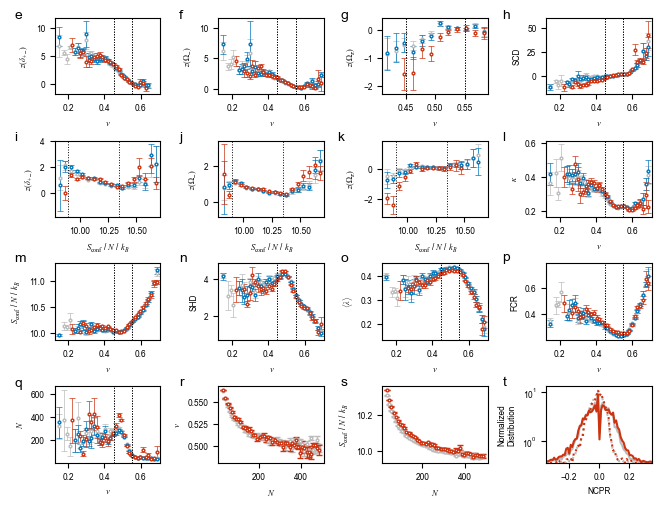

In [19]:
f, axes = plt.subplots(4, 4, sharex=False, sharey=False, figsize=(6.6,5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

features = ['z_delta_+-','z_omega_-','z_omega_pi','scd','kappa','SPR','shd','mean_lambda','fcr','N']
labels = ['$z(\delta_{+-})$','$z(\Omega_{-})$','$z(\Omega_{\pi})$','SCD','$\kappa$',
          r'$S_\mathrm{conf}$ / $N$ / $k_B$','SHD',r'$\langle \lambda \rangle$','FCR','$N$']

bin_width = .015
bins = np.arange(0.14, .701, bin_width)
x = bins[:-1]+bin_width/2

for ax,feature,label in zip(np.append(axes.flatten()[:4],axes.flatten()[7:]),features,labels):
    
    if feature == 'z_delta_+-':
        nonzero_bool = df_idrome['z_delta_+-'] != 0
    elif feature == 'z_omega_-':
        nonzero_bool = df_idrome['z_omega_-'] != 0
    elif feature == 'z_omega_pi':
        nonzero_bool = df_idrome['z_omega_pi'] != 0
    else:
        nonzero_bool = np.ones(df_idrome[feature].size,dtype=bool)

    average = binned_statistic(df_idrome.nu.values[nonzero_bool],
                               df_idrome[feature].values[nonzero_bool],bins=bins)[0]
    standard_error = binned_statistic(df_idrome.nu.values[nonzero_bool],
                                      df_idrome[feature].values[nonzero_bool],statistic=se,
                                      bins=bins)[0]
    counts = binned_statistic(df_idrome.nu.values[nonzero_bool],
                               df_idrome[feature].values[nonzero_bool],bins=bins,statistic='count')[0]
    
    ax.errorbar(x[counts>2],average[counts>2],yerr=standard_error[counts>2],ms=2,marker='o',lw=0,zorder=0,mfc='w',
             elinewidth=.5,capsize=2,capthick=.5,label=label,color=pt_colors['grey'])
    ax.set_xlim(.125,.708)
    ax.set_xticks(np.arange(.2,.71,.2))
    
for ax,feature,label in zip(np.append(axes.flatten()[:4],axes.flatten()[7:]),features,labels):
    
    if feature == 'z_delta_+-':
        nonzero_bool = df_idrome.query('fdomain==0')['z_delta_+-'] != 0
    elif feature == 'z_omega_-':
        nonzero_bool = df_idrome.query('fdomain==0')['z_omega_-'] != 0
    elif feature == 'z_omega_pi':
        nonzero_bool = df_idrome.query('fdomain==0')['z_omega_pi'] != 0
    else:
        nonzero_bool = np.ones(df_idrome.query('fdomain==0')[feature].size,dtype=bool)
    
    average = binned_statistic(df_idrome.query('fdomain==0').nu.values[nonzero_bool],
                               df_idrome.query('fdomain==0')[feature].values[nonzero_bool],bins=bins)[0]
    standard_error = binned_statistic(df_idrome.query('fdomain==0').nu.values[nonzero_bool],
                                      df_idrome.query('fdomain==0')[feature].values[nonzero_bool],statistic=se,
                                      bins=bins)[0]
    counts = binned_statistic(df_idrome.query('fdomain==0').nu.values[nonzero_bool],
                               df_idrome.query('fdomain==0')[feature].values[nonzero_bool],
                               bins=bins,statistic='count')[0]
    
    ax.errorbar(x[counts>2],average[counts>2],yerr=standard_error[counts>2],ms=2,marker='o',lw=0,zorder=0,mfc='w',
             elinewidth=.5,capsize=2,capthick=.5,label=label,color=pt_colors['blue'])

    ax.set_ylabel(label)
    
    ax.axvline(.45,color='k',ls=':',lw=.7)
    ax.axvline(.55,color='k',ls=':',lw=.7)
    ax.set_xlim(.125,.708)
    ax.set_xticks(np.arange(.2,.71,.2))
    ax.set_xlabel('$\\nu$')
    
features = ['z_delta_+-','z_omega_-','z_omega_pi','scd','kappa','SPR_svr','shd','mean_lambda','fcr','N']
labels = ['$z(\delta_{+-})$','$z(\Omega_{-})$','$z(\Omega_{\pi})$','SCD','$\kappa$',
          r'$S_\mathrm{conf}$ / $N$ / $k_B$','SHD',r'$\langle \lambda \rangle$','FCR','$N$']

for ax,feature,label in zip(np.append(axes.flatten()[:4],axes.flatten()[7:]),features,labels):
    
    if feature == 'z_delta_+-':
        nonzero_bool = df_idrome_spot['z_delta_+-'] != 0
    elif feature == 'z_omega_-':
        nonzero_bool = df_idrome_spot['z_omega_-'] != 0
    elif feature == 'z_omega_pi':
        nonzero_bool = df_idrome_spot['z_omega_pi'] != 0
    else:
        nonzero_bool = np.ones(df_idrome_spot[feature].size,dtype=bool)
    
    average = binned_statistic(df_idrome_spot.nu_svr.values[nonzero_bool],
                               df_idrome_spot[feature].values[nonzero_bool],bins=bins)[0]
    standard_error = binned_statistic(df_idrome_spot.nu_svr.values[nonzero_bool],
                                      df_idrome_spot[feature].values[nonzero_bool],statistic=se,
                                      bins=bins)[0]
    counts = binned_statistic(df_idrome_spot.nu_svr.values[nonzero_bool],
                                      df_idrome_spot[feature].values[nonzero_bool],statistic='count',
                                      bins=bins)[0]
    
    ax.errorbar(x[counts>2],average[counts>2],yerr=standard_error[counts>2],ms=2,
             marker='o',lw=0,zorder=0,mfc='w',
             elinewidth=.5,capsize=2,capthick=.5,label=label,color=pt_colors['red'])

    ax.set_ylabel(label)
    
    ax.axvline(.45,color='k',ls=':',lw=.7)
    ax.axvline(.55,color='k',ls=':',lw=.7)
    ax.set_xlim(.125,.708)
    ax.set_xticks(np.arange(.2,.71,.2))
    ax.set_xlabel('$\\nu$')
    
#######

features = ['z_delta_+-','z_omega_-','z_omega_pi']
labels = ['$z(\delta_{+-})$','$z(\Omega_{-})$','$z(\Omega_{\pi})$']

bin_width = .05
bins = np.arange(9.8, 10.75, bin_width)
x = bins[:-1]+bin_width/2

for ax,feature,label in zip(axes.flatten()[4:],features,labels):
    
    if feature == 'z_delta_+-':
        nonzero_bool = df_idrome['z_delta_+-'] != 0
    elif feature == 'z_omega_-':
        nonzero_bool = df_idrome['z_omega_-'] != 0
    elif feature == 'z_omega_pi':
        nonzero_bool = df_idrome['z_omega_pi'] != 0
    else:
        nonzero_bool = np.ones(df_idrome[feature].size,dtype=bool)

    average = binned_statistic(df_idrome.SPR.values[nonzero_bool],
                               df_idrome[feature].values[nonzero_bool],bins=bins)[0]
    standard_error = binned_statistic(df_idrome.SPR.values[nonzero_bool],
                                      df_idrome[feature].values[nonzero_bool],statistic=se,
                                      bins=bins)[0]
    counts = binned_statistic(df_idrome.SPR.values[nonzero_bool],
                                      df_idrome[feature].values[nonzero_bool],statistic='count',
                                      bins=bins)[0]
    
    ax.errorbar(x[counts>2],average[counts>2],yerr=standard_error[counts>2],ms=2,
             marker='o',lw=0,zorder=0,mfc='w',
             elinewidth=.5,capsize=2,capthick=.5,label=label,color=pt_colors['grey'])
    
    ax.axvline(9.9,color='k',ls=':',lw=.7)
    ax.axvline(10.35,color='k',ls=':',lw=.7)
    
for ax,feature,label in zip(axes.flatten()[4:],features,labels):
    
    if feature == 'z_delta_+-':
        nonzero_bool = df_idrome.query('fdomain==0')['z_delta_+-'] != 0
    elif feature == 'z_omega_-':
        nonzero_bool = df_idrome.query('fdomain==0')['z_omega_-'] != 0
    elif feature == 'z_omega_pi':
        nonzero_bool = df_idrome.query('fdomain==0')['z_omega_pi'] != 0
    else:
        nonzero_bool = np.ones(df_idrome.query('fdomain==0')[feature].size,dtype=bool)
    
    average = binned_statistic(df_idrome.query('fdomain==0').SPR.values[nonzero_bool],
                               df_idrome.query('fdomain==0')[feature].values[nonzero_bool],bins=bins)[0]
    standard_error = binned_statistic(df_idrome.query('fdomain==0').SPR.values[nonzero_bool],
          df_idrome.query('fdomain==0')[feature].values[nonzero_bool],statistic=se,
          bins=bins)[0]
    counts = binned_statistic(df_idrome.query('fdomain==0').SPR.values[nonzero_bool],
          df_idrome.query('fdomain==0')[feature].values[nonzero_bool],statistic='count',
          bins=bins)[0]
    
    ax.errorbar(x[counts>2],average[counts>2],yerr=standard_error[counts>2],ms=2,marker='o',
             lw=0,zorder=0,mfc='w',
             elinewidth=.5,capsize=2,capthick=.5,label=label,color=pt_colors['blue'])
    
    ax.set_ylabel(label)
    
    ax.set_xlabel(r'$S_\mathrm{conf}$ / $N$ / $k_B$')
    ax.set_xlim(9.78,10.71)

for ax,feature,label in zip(axes.flatten()[4:],features,labels):
    
    if feature == 'z_delta_+-':
        nonzero_bool = df_idrome_spot['z_delta_+-'] != 0
    elif feature == 'z_omega_-':
        nonzero_bool = df_idrome_spot['z_omega_-'] != 0
    elif feature == 'z_omega_pi':
        nonzero_bool = df_idrome_spot['z_omega_pi'] != 0
    else:
        nonzero_bool = np.ones(df_idrome_spot[feature].size,dtype=bool)
    
    average = binned_statistic(df_idrome_spot.SPR_svr.values[nonzero_bool],
                               df_idrome_spot[feature].values[nonzero_bool],bins=bins)[0]
    standard_error = binned_statistic(df_idrome_spot.SPR_svr.values[nonzero_bool],
                                      df_idrome_spot[feature].values[nonzero_bool],statistic=se,
                                      bins=bins)[0]
    counts = binned_statistic(df_idrome_spot.SPR_svr.values[nonzero_bool],
                                      df_idrome_spot[feature].values[nonzero_bool],statistic='count',
                                      bins=bins)[0]
    
    ax.errorbar(x[counts>2],average[counts>2],yerr=standard_error[counts>2],ms=2,
             marker='o',lw=0,zorder=0,mfc='w',
             elinewidth=.5,capsize=2,capthick=.5,label=label,color=pt_colors['red'])
    
    ax.set_ylabel(label)
    
    ax.set_xlabel(r'$S_\mathrm{conf}$ / $N$ / $k_B$')
    ax.set_xlim(9.78,10.71)

axes[0,2].set_xlim(.41,.59)
axes[0,2].set_ylim(-2.3,.45)
axes[0,2].set_xticks(np.array([.45,.5,.55]))

#########

ax1 = axes.flatten()[-3]
ax2 = axes.flatten()[-2]
ax3 = axes.flatten()[-1]

bins = np.arange(30, 500, 10)
x = bins[:-1]+5

average = binned_statistic(df_idrome.N,df_idrome.nu,bins=bins)[0]
standard_error = binned_statistic(df_idrome.N,df_idrome.nu,statistic=se,
                                     bins=bins)[0]
counts = binned_statistic(df_idrome.N,df_idrome.nu,statistic='count',
                                     bins=bins)[0]

ax1.errorbar(x[counts>2],average[counts>2],yerr=standard_error[counts>2],ms=2,marker='o',lw=0,zorder=0,mfc='w',
             elinewidth=1,capsize=2,capthick=1,color=pt_colors['grey'])

average = binned_statistic(df_idrome_spot.N,df_idrome_spot.nu_svr,bins=bins)[0]
standard_error = binned_statistic(df_idrome_spot.N,df_idrome_spot.nu_svr,statistic=se,
                                     bins=bins)[0]
counts = binned_statistic(df_idrome_spot.N,df_idrome_spot.nu_svr,statistic='count',
                                     bins=bins)[0]

ax1.errorbar(x[counts>2],average[counts>2],yerr=standard_error[counts>2],ms=2,marker='o',lw=0,zorder=0,mfc='w',
             elinewidth=1,capsize=2,capthick=1,color=pt_colors['red'])

average = binned_statistic(df_idrome.N,df_idrome.SPR,bins=bins)[0]
standard_error = binned_statistic(df_idrome.N,df_idrome.SPR,statistic=se,
                                     bins=bins)[0]
counts = binned_statistic(df_idrome.N,df_idrome.SPR,statistic='count',
                                     bins=bins)[0]

ax2.errorbar(x[counts>2],average[counts>2],yerr=standard_error[counts>2],ms=2,marker='o',lw=0,zorder=0,mfc='w',
             elinewidth=1,capsize=2,capthick=1,color=pt_colors['grey'])

average = binned_statistic(df_idrome_spot.N,df_idrome_spot.SPR_svr,bins=bins)[0]
standard_error = binned_statistic(df_idrome_spot.N,df_idrome_spot.SPR_svr,statistic=se,
                                     bins=bins)[0]
counts = binned_statistic(df_idrome_spot.N,df_idrome_spot.SPR_svr,statistic='count',
                                     bins=bins)[0]

ax2.errorbar(x[counts>2],average[counts>2],yerr=standard_error[counts>2],ms=2,marker='o',lw=0,zorder=0,mfc='w',
             elinewidth=1,capsize=2,capthick=1,color=pt_colors['red'])

bins = np.arange(-.4, .4, .01)
x = bins[:-1]+.0025

h = np.histogram(df_idrome.query('N<=200')['ncpr'],bins=bins,density=True)[0]
ax3.plot(x,h,color=pt_colors['grey'])

h = np.histogram(df_idrome.query('N>200')['ncpr'],bins=bins,density=True)[0]
ax3.plot(x,h,color=pt_colors['grey'],ls=':')

bins = np.arange(-.4, .4, .01)
x = bins[:-1]+.0025

h = np.histogram(df_idrome_spot.query('N<=200')['ncpr'],bins=bins,density=True)[0]
ax3.plot(x,h,color=pt_colors['red'])

h = np.histogram(df_idrome_spot.query('N>200')['ncpr'],bins=bins,density=True)[0]
ax3.plot(x,h,color=pt_colors['red'],ls=':')

ax1.set_ylabel('$\\nu$')
ax2.set_ylabel(r'$S_\mathrm{conf}$ / $N$ / $k_B$')
ax1.set_xlabel('$N$')
ax2.set_xlabel('$N$')

ax3.set_ylabel('Normalized\nDistribution')
ax3.set_xlabel('NCPR')
#ax3.legend(frameon=False,loc='upper left',ncols=1,borderpad=.1,handlelength=1.8)
ax3.set_xlim(-.35,.35)
ax3.set_ylim(1e-2,14)
ax3.set_yscale('symlog')

axes.flatten()[4].set_ylim(-1.8,4)

f.text(0.02, .975, 'e', fontsize=10)
f.text(0.27, .975, 'f', fontsize=10)
f.text(0.515, .975, 'g', fontsize=10)
f.text(0.76, .975, 'h', fontsize=10)

f.text(0.02, .73, 'i', fontsize=10)
f.text(0.27, .73, 'j', fontsize=10)
f.text(0.51, .73, 'k', fontsize=10)
f.text(0.76, .73, 'l', fontsize=10)

f.text(0.02, .49, 'm', fontsize=10)
f.text(0.27, .49, 'n', fontsize=10)
f.text(0.515, .49, 'o', fontsize=10)
f.text(0.76, .49, 'p', fontsize=10)

f.text(0.02, .24, 'q', fontsize=10)
f.text(0.27, .24, 'r', fontsize=10)
f.text(0.515, .24, 's', fontsize=10)
f.text(0.76, .24, 't', fontsize=10)

plt.tight_layout()

f.savefig('figs/ED_fig6b.pdf',dpi=300)

#### Extended Data Fig. 7

mean_lambda 4, 3, 5, 3, 5, 6, 9, 11, 8, 16, 14, 26, 23, 28, 41, 49, 98, 135, 212, 473, 854, 1921, 3319, 4724, 5393, 4987, 3405, 1461, 484, 182, 76, 43, 16, 9, 4
f- 4, 3, 5, 3, 5, 6, 9, 11, 8, 16, 14, 26, 23, 28, 41, 49, 98, 135, 212, 473, 854, 1921, 3319, 4724, 5393, 4987, 3405, 1461, 484, 182, 76, 43, 16, 9, 4
fR 4; 3; 5; 3; 5; 6; 9; 11; 8; 16; 14; 26; 23; 28; 41; 49; 98; 135; 212; 473; 854; 1921; 3319; 4724; 5393; 4987; 3405; 1461; 484; 182; 76; 43; 16; 9; 4
fR 5; 9; 4; 20; 29; 93; 406; 1290; 2555; 3204; 3520; 3483; 3415; 3005; 2517; 1895; 1208; 686; 320; 161; 90; 49; 29; 20; 12; 6; 8; 4; 3; 3; 3


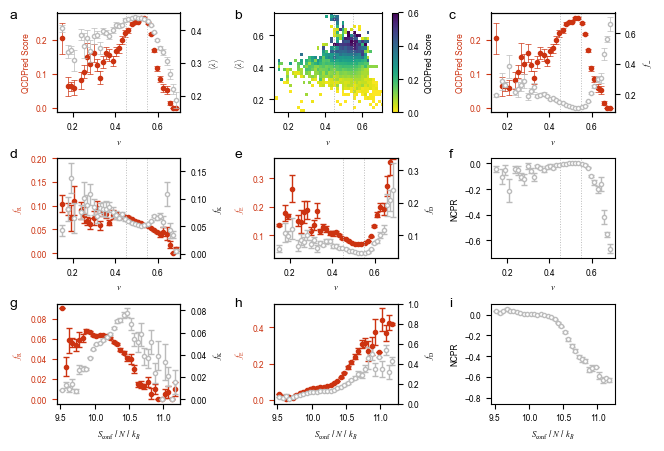

In [28]:
f, axes = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(6.6,4.5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

#qcdpred = pd.read_csv('QCDPred/idr_qcdpred.txt.gz',header=None,sep='\s+',usecols=[0,2],
#                    names=['seq_name','QCDpred']).groupby('seq_name').mean()
#df_idrome['QCDpred'] = qcdpred.loc[df_idrome.index].QCDpred

ax1,ax2,ax3 = axes[0,0],axes[0,1],axes[0,2]

df_idrome['f-'] = df_idrome['fE'] + df_idrome['fD']

for ax,feature,interval,tlabel in zip([ax1,ax3],['mean_lambda','f-'],[.015,.015],
                              [r'$\langle \lambda \rangle$',r'$f_-$']):   
    xbins = np.arange(0.14, .701, interval)
    xbins_center = xbins[:-1]+interval/2

    average = binned_statistic(df_idrome['nu'],df_idrome['QCDpred'],bins=xbins)[0]
    standard_error = binned_statistic(df_idrome['nu'],df_idrome['QCDpred'],statistic=se,
                                         bins=xbins)[0]
    counts = binned_statistic(df_idrome['nu'],df_idrome['QCDpred'],statistic='count',
                                         bins=xbins)[0]
    print(feature,', '.join([str(int(x)) for x in counts[counts>2]]))
    ax.errorbar(xbins_center[counts>2],average[counts>2],yerr=standard_error[counts>2],ms=3,marker='o',lw=0,
                 elinewidth=.5,capsize=2,capthick=.5,color=pt_colors['red'])
    ax.set_ylabel(r'QCDPred Score',color=pt_colors['red'])
    ax.tick_params(axis='y',colors=pt_colors['red'])
    axt = ax.twinx()
    average = binned_statistic(df_idrome['nu'],df_idrome[feature],bins=xbins)[0]
    standard_error = binned_statistic(df_idrome['nu'],df_idrome[feature],statistic=se,
                                         bins=xbins)[0]
    counts = binned_statistic(df_idrome['nu'],df_idrome[feature],statistic='count',
                                         bins=xbins)[0]
    axt.errorbar(xbins_center[counts>2],average[counts>2],yerr=standard_error[counts>2],ms=3,
                 marker='o',lw=0,mfc='w',
                 elinewidth=.5,capsize=2,capthick=.5,color=pt_colors['grey'])
    axt.set_ylabel(tlabel)
    axt.tick_params(axis='y')
    ax.set_xlim(.125,.708)
    axt.set_xlim(.125,.708)
    
xbins = np.round(np.arange(df_idrome['nu'].min(),df_idrome['nu'].max(),interval),2)
ybins = np.round(np.arange(df_idrome['mean_lambda'].min(),df_idrome['mean_lambda'].max(),.02),2)
xbins_center = xbins[:-1] + .02/2
ybins_center = ybins[:-1] + .02/2

h,_,_,_ = binned_statistic_2d(df_idrome['mean_lambda'],
            df_idrome['nu'],
            bins=[ybins,xbins],
            values=df_idrome['QCDpred'],statistic='mean')
im = ax2.imshow(h, cmap=plt.cm.viridis_r,
                 origin='lower',alpha=1,extent=[xbins_center.min(),xbins_center.max(),
                                        ybins_center.min(),ybins_center.max()],
                 vmin=0,vmax=.6,aspect='auto',interpolation='nearest')

divider = make_axes_locatable(ax2)
cax = divider.new_horizontal(size="5%", pad=0.1)
f.add_axes(cax)
cbar = plt.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('QCDPred Score',labelpad=4)
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')

ax2.set_ylabel(r'$\langle \lambda \rangle$')
    
#############

ax4,ax5,ax6 = axes[1,0],axes[1,1],axes[1,2]

bin_width = .015
bins = np.arange(0.14, .701, bin_width)
x = bins[:-1]+bin_width/2

average = binned_statistic(df_idrome.nu,df_idrome['fR'],bins=bins)[0]
standard_error = binned_statistic(df_idrome.nu,df_idrome['fR'],statistic=se,
                                     bins=bins)[0]
counts = binned_statistic(df_idrome.nu,df_idrome['fR'],statistic='count',
                                     bins=bins)[0]
print('fR','; '.join([str(int(x)) for x in counts[counts>2]]))
ax4.errorbar(x[counts>2],average[counts>2],yerr=standard_error[counts>2],ms=3,
             marker='o',lw=0,zorder=0,
             elinewidth=1,capsize=2,capthick=1,color=pt_colors['red'])
ax4.set_ylabel('$f_\mathrm{R}$',color=pt_colors['red'])
ax4.tick_params(axis='y',colors=pt_colors['red'])
#############
average = binned_statistic(df_idrome.nu,df_idrome['fK'],bins=bins)[0]
standard_error = binned_statistic(df_idrome.nu,df_idrome['fK'],statistic=se,
                                     bins=bins)[0]
counts = binned_statistic(df_idrome.nu,df_idrome['fK'],statistic='count',
                                     bins=bins)[0]
axt = ax4.twinx()
axt.errorbar(x[counts>2],average[counts>2],yerr=standard_error[counts>2],ms=3,marker='o',lw=0,zorder=0,mfc='w',
             elinewidth=1,capsize=2,capthick=1,color=pt_colors['grey'])
axt.set_ylabel('$f_\mathrm{K}$')
#############
average = binned_statistic(df_idrome.nu,df_idrome['fE'],bins=bins)[0]
standard_error = binned_statistic(df_idrome.nu,df_idrome['fE'],statistic=se,
                                     bins=bins)[0]
counts = binned_statistic(df_idrome.nu,df_idrome['fE'],statistic='count',
                                     bins=bins)[0]
ax5.errorbar(x[counts>2],average[counts>2],yerr=standard_error[counts>2],ms=3,marker='o',lw=0,zorder=0,
             elinewidth=1,capsize=2,capthick=1,label='E',color=pt_colors['red'])
ax5.set_ylabel('$f_\mathrm{E}$',color=pt_colors['red'])
ax5.tick_params(axis='y',colors=pt_colors['red'])
#############
average = binned_statistic(df_idrome.nu,df_idrome['fD'],bins=bins)[0]
standard_error = binned_statistic(df_idrome.nu,df_idrome['fD'],statistic=se,
                                     bins=bins)[0]
counts = binned_statistic(df_idrome.nu,df_idrome['fD'],statistic='count',
                                     bins=bins)[0]
axt = ax5.twinx()
axt.errorbar(x[counts>2],average[counts>2],yerr=standard_error[counts>2],ms=3,
             marker='o',lw=0,zorder=0,mfc='w',
             elinewidth=1,capsize=2,capthick=1,color=pt_colors['grey'],label='D')
axt.set_ylabel('$f_\mathrm{D}$')
#############
average = binned_statistic(df_idrome.nu,df_idrome['ncpr'],bins=bins)[0]
standard_error = binned_statistic(df_idrome.nu,df_idrome['ncpr'],statistic=se,
                                     bins=bins)[0]
counts = binned_statistic(df_idrome.nu,df_idrome['ncpr'],statistic='count',
                                     bins=bins)[0]
ax6.errorbar(x[counts>2],average[counts>2],yerr=standard_error[counts>2],ms=3,
             marker='o',lw=0,zorder=0,mfc='w',
             elinewidth=1,capsize=2,capthick=1,color=pt_colors['grey'],label='D')
#############
ax7,ax8,ax9 = axes[2,0],axes[2,1],axes[2,2]

bin_width = .05
bins = np.arange(9.5, 11.4, bin_width)
x = bins[:-1]+bin_width/2

average = binned_statistic(df_idrome.SPR,df_idrome['fR'],bins=bins)[0]
standard_error = binned_statistic(df_idrome.SPR,df_idrome['fR'],statistic=se,
                                     bins=bins)[0]
standard_error = binned_statistic(df_idrome.SPR,df_idrome['fR'],statistic=se,
                                     bins=bins)[0]
counts = binned_statistic(df_idrome.SPR,df_idrome['fR'],statistic='count',
                                     bins=bins)[0]
print('fR','; '.join([str(int(x)) for x in counts[counts>2]]))

ax7.errorbar(x[counts>0],average[counts>0],yerr=standard_error[counts>0],ms=3,marker='o',lw=0,zorder=0,
             elinewidth=1,capsize=2,capthick=1,label='R',color=pt_colors['red'])
ax7.set_ylabel('$f_\mathrm{R}$',color=pt_colors['red'])
ax7.tick_params(axis='y',colors=pt_colors['red'])
#############
average = binned_statistic(df_idrome.SPR,df_idrome['fK'],bins=bins)[0]
standard_error = binned_statistic(df_idrome.SPR,df_idrome['fK'],statistic=se,
                                     bins=bins)[0]
counts = binned_statistic(df_idrome.SPR,df_idrome['fK'],statistic='count',
                                     bins=bins)[0]
axt = ax7.twinx()
axt.errorbar(x[counts>0],average[counts>0],yerr=standard_error[counts>0],ms=3,marker='o',lw=0,zorder=0,mfc='w',
             elinewidth=1,capsize=2,capthick=1,color=pt_colors['grey'],label=pt_colors['grey'])
axt.set_ylabel('$f_\mathrm{K}$')
#############
average = binned_statistic(df_idrome.SPR,df_idrome['fE'],bins=bins)[0]
standard_error = binned_statistic(df_idrome.SPR,df_idrome['fE'],statistic=se,
                                     bins=bins)[0]
counts = binned_statistic(df_idrome.SPR,df_idrome['fE'],statistic='count',
                                     bins=bins)[0]
ax8.errorbar(x[counts>0],average[counts>0],yerr=standard_error[counts>0],ms=3,marker='o',lw=0,zorder=0,
             elinewidth=1,capsize=2,capthick=1,label='E',color=pt_colors['red'])
ax8.set_ylabel('$f_\mathrm{E}$',color=pt_colors['red'])
ax8.tick_params(axis='y',colors=pt_colors['red'])
#############
average = binned_statistic(df_idrome.SPR,df_idrome['fD'],bins=bins)[0]
standard_error = binned_statistic(df_idrome.SPR,df_idrome['fD'],statistic=se,
                                     bins=bins)[0]
counts = binned_statistic(df_idrome.SPR,df_idrome['fD'],statistic='count',
                                     bins=bins)[0]
axt = ax8.twinx()
ax8.errorbar(x[counts>0],average[counts>0],yerr=standard_error[counts>0],ms=3,marker='o',lw=0,zorder=0,mfc='w',
             elinewidth=1,capsize=2,capthick=1,color=pt_colors['grey'],label='D')
axt.set_ylabel('$f_\mathrm{D}$')
#############
average = binned_statistic(df_idrome.SPR,df_idrome['ncpr'],bins=bins)[0]
standard_error = binned_statistic(df_idrome.SPR,df_idrome['ncpr'],statistic=se,
                                     bins=bins)[0]
counts = binned_statistic(df_idrome.SPR,df_idrome['ncpr'],statistic='count',
                                     bins=bins)[0]
ax9.errorbar(x[counts>0],average[counts>0],yerr=standard_error[counts>0],ms=3,marker='o',lw=0,zorder=0,mfc='w',
             elinewidth=1,capsize=2,capthick=1,color=pt_colors['grey'],label='D')
#############
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.axvline(.45,color=pt_colors['grey'],ls=':',lw=.7)
    ax.axvline(.55,color=pt_colors['grey'],ls=':',lw=.7)
    ax.set_xlabel('$\\nu$')
    ax.set_xticks(np.arange(.2,.71,.2))
    ax.set_xlim(.125,.708)
for ax in [ax7,ax8,ax9]:    
    ax.set_xlim(9.45,11.25)

ax4.set_ylim(-.01,.2)
ax5.set_ylim(0.02,.37)

ax7.set_xlabel(r'$S_\mathrm{conf}$ / $N$ / $k_B$')
ax8.set_xlabel(r'$S_\mathrm{conf}$ / $N$ / $k_B$')
ax9.set_xlabel(r'$S_\mathrm{conf}$ / $N$ / $k_B$')

ax6.set_ylabel('NCPR')
ax9.set_ylabel('NCPR')

f.text(0.01, .96, 'a', fontsize=10)
f.text(0.35, .96, 'b', fontsize=10)
f.text(0.675, .96, 'c', fontsize=10)

f.text(0.01, .65, 'd', fontsize=10)
f.text(0.35, .65, 'e', fontsize=10)
f.text(0.675, .65, 'f', fontsize=10)

f.text(0.01, .32, 'g', fontsize=10)
f.text(0.35, .32, 'h', fontsize=10)
f.text(0.675, .32, 'i', fontsize=10)

plt.tight_layout()

f.savefig('figs/ED_fig7.jpg',dpi=600)

#### Excess of R vs K in compact IDRs

In [21]:
round(df_idrome.query('nu <= .475')['fR'].mean()*100,1),round(df_idrome.query('nu <= .475')['fK'].mean()*100,1)

(7.7, 6.5)

In [22]:
se(df_idrome.query('nu <= .475')['fR'])*100,se(df_idrome.query('nu <= .475')['fK'])*100

(0.09971716653293305, 0.12643941649675586)